In [1]:
import os
from itertools import compress
from pathlib import Path

import autoreject
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from autoreject import get_rejection_threshold
from scipy.integrate import simpson
from Settings import *
from utils import *

In [2]:
mne.set_log_level(False)
mne.utils.set_config('MNE_USE_CUDA', 'true')  
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
icas = []

lstPIds = []
path = "../Data/"
for filename in os.listdir(path):
    if filename.endswith(".csv"): 
        lstPIds.append(int(filename.split("-")[0].replace("ID", "")))
    else:
        continue
lstPIds = list(set(lstPIds))
print(lstPIds)
print(str(len(lstPIds)) + " subjects")

#for TESTING
if TEST:
    lstPIds = [1, 2]
    lstPIds = list(set(lstPIds))
    NUM_BLOCKS = 2

[1, 2, 3, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
17 subjects


In [4]:
dir_path = r'./fifs'
Path('./fifs').mkdir(parents=True, exist_ok=True)
Path('./pickles').mkdir(parents=True, exist_ok=True)
Path('./Plots/ICA').mkdir(parents=True, exist_ok=True)
Path('./ica/fifs').mkdir(parents=True, exist_ok=True)

arr_epochs = []

if len(os.listdir('./fifs')) != NUM_BLOCKS * len(lstPIds):
                           
    for pid in tqdm.tqdm(lstPIds):

        if len(os.listdir('./fifs/')) != NUM_BLOCKS * len(lstPIds):
            dfState = pd.read_csv(f"{path}ID{pid}-state.csv")
                
            dfEEG = pd.read_csv(f"{path}ID{pid}-EEG.csv")
            dfEEG.rename(columns={"Value0": "F3", "Value1": "C3", "Value2": "P3", "Value3": "P4", "Value4": "C4", "Value5": "F4", "Value6": "Pz"}, inplace=True)
            dfEEG.drop("TimeLsl", axis =1, inplace=True)
            dfEEG.rename(columns={"TimeLsl": "Time"}, inplace=True)

            dstate = pd.read_csv(f"{path}ID{pid}-state.csv")
            
            dfAll = pd.merge(dfEEG, dstate, on =["Time"], how="outer")
            dfAll.sort_values(by="Time", inplace=True) # inplace?
            
            dfAll.drop(columns=["Value7","AdaptationStatus", "NBackN", "State"], inplace=True)
            dfAll.fillna(method='ffill', inplace=True)
            dfAll.drop(dfAll[dfAll.BlockNumber < 0].index, inplace=True)
            dfAll.dropna(inplace=True)

            for x in range(1, NUM_BLOCKS+1):  
                
                # Prepare data 
                # see if fif already present, else filter / clean data and save it
                        
                data = dfAll.loc[dfAll['BlockNumber'] == x]
                df = pd.DataFrame(data)
                # data.plot(x="Time", y=["F3", "C3","P3","P3","C4","F4","Pz"])

                info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
                info.set_montage('standard_1020',  match_case=False)

                samples = df.T
                
                raw = mne.io.RawArray(samples, info)
                raw.drop_channels(['Time', 'BlockNumber'])
                
                # remove power line interferance
                raw.notch_filter(50., n_jobs=-1)
                
                # high pass filter to remove slow drifts, 70 Hz low pass
                raw.filter(1., 70, None, fir_design='firwin')
                
                # set EEG reference
                raw.set_eeg_reference('average', projection=True)
                #raw.set_eeg_reference(ref_channels=['Pz'])
                
                # Visual inspection of bad channels
                # TODO, empty for now. With new setup, check for bad channels only once for all blocks.
                raw.info['bads'] =  bads[pid-1][x-1]
                if raw.info['bads']:
                    raw.interpolate_bads()
   
                # Create equal length epochs of 4 seconds
                epochs = mne.make_fixed_length_epochs(raw.copy(), preload=True, duration = epochs_tstep)
                
                # Global autoreject based on rejection threshold
                reject = get_rejection_threshold(epochs, ch_types = 'eeg', verbose=False)      
                #print("The rejection dictionary is %s " %reject)
                epochs.drop_bad(reject=reject)
                #epochs.plot_drop_log()
                
                #arr_epochs.append(epochs)
                epochs.save('./fifs/' + str(pid) + '-' + str(x) + '-epo.fif', overwrite = True)

In [5]:
exclude_ic = [] # TODO sure its here?
action = None

for pid in tqdm.tqdm(lstPIds):

    if action == 'no':
        pick_ic_as_template = False
    else:
        if pick_ic_as_template:
            action = get_user_input(valid_response={'no', 'yes'},
                        prompt="Select ICs for ICE corrmap? - yes | no", 
                        err_prompt="Type  \"yes\" or \"no\": \n")
        
        if action == 'no':
            pick_ic_as_template = False
                
    for x in range(1, NUM_BLOCKS+1):  
        
        epochs = mne.read_epochs('./fifs/' + str(pid) + '-' + str(x) + '-epo.fif', preload=True)
        
        if len(os.listdir('./ica/fifs/')) != NUM_BLOCKS * len(lstPIds):
            
            # independent component analysis (ICA)
            ica = mne.preprocessing.ICA(method="fastica",  random_state=97)
            
            #TODO decide later. if yes, dont forget to redo it after ica apply
            local_autoreject = False
            if local_autoreject:
                ar = autoreject.AutoReject(n_jobs=-1,  verbose=True, random_state=11)
                epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True) 
                reject_log.plot('horizontal')
                evoked_bad = epochs[reject_log.bad_epochs].average()
                plt.figure()
                plt.plot(evoked_bad.times, evoked_bad.data.T * 1e6, 'r', zorder=-1)
                epochs_clean.average().plot(axes=plt.gca())
                #epochs = epochs_clean
                ica.fit(epochs[~reject_log.bad_epochs], tstep = epochs_tstep)

            ica.fit(epochs)
            ica.save('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif', overwrite = True)
            
        else:
            ica = mne.preprocessing.read_ica('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif')
         
        # Optionally autoreject muscle and eog artifacts
        if (pick_ic_auto):
            #start fresh, else find_bads_muscle fails
            ica.exclude = []
            
            ica_z_thresh = 1.96
            eog_indices, eog_scores = ica.find_bads_eog(epochs, 
                                                        ch_name=['F3', 'F4'], 
                                                        threshold=ica_z_thresh)
            print(f'Automatically found eye artifact ICA components: {eog_indices}')

            # ica.plot_scores(eog_scores)  
            muscle_idx_auto = []
            
            #TODO make true again, just not with  this data...
            if(True):
                muscle_idx_auto, scores = ica.find_bads_muscle(epochs)
                #ica.plot_scores(scores, exclude=muscle_idx_auto)
                print(f'Automatically found muscle artifact ICA components: {muscle_idx_auto}')
            
            for item in muscle_idx_auto + eog_indices :
                if item not in ica.exclude:
                    ica.exclude.append(item)
                    
            #print("excludes are" , ica.exclude)
            #ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg', title = str(pid) + '-' + str(x) )

        # Pick templates
        if(pick_ic_as_template):
            done = False
            while not done:
                
                ics_old = ica.exclude
                ica.plot_properties(epochs, dB= True, log_scale= True, psd_args={'fmax':70})
                ica.plot_sources(epochs, block = True, title = str(pid) + '-' + str(x), stop = 360. )
                ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg', stop = 360.)

                while True:
                    accept = get_user_input(valid_response={'no', 'yes'},
                                            prompt="Accept? - yes | no",
                                            err_prompt = "yes | no")
                    try:
                        if accept == 'yes':
                            ica.save('./ica/'+ str(pid) + '-' + str (x) + '_template-ica.fif', overwrite = True)
                            ica.save('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif', overwrite = True)
                            done = True
                            quit = get_user_input(valid_response={'no', 'yes'},
                                        prompt="Quit? - yes | no",
                                        err_prompt = "yes | no")                   
                            if quit == 'yes':
                                pick_ic_as_template = False
                                break
                            break
                        else:
                            ica.exclude = ics_old # doesn't to anything
                            quit = get_user_input(valid_response={'no', 'yes'},
                                            prompt="Quit? - yes | no",
                                            err_prompt = "yes | no")                       
                            if quit == 'yes':
                                pick_ic_as_template = False
                                done = True
                                break     
                            else:
                                break              
                    except Exception as e:
                        print(e)
        
        # TODO remove save ica from template picker  
        # if there are excludes in ica, template doesnt work :DDDD      
        ica.save('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif', overwrite = True)       
           
        #TODO put this somewhere else
        clean_ica_excludes = False
        if(clean_ica_excludes):
            print("removing excludes")
            ica.exclude = []
            ica.save('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif', overwrite = True)   
              
        #TODO maybe do a size check before appending                                  
        # save the ICAs for the corrmap 
        icas.append(ica)
        arr_epochs.append(epochs)
        # epochs.save("./ica/pipeline_1/raw/"+str(pid)+"_"+str(x)+".fif")

100%|██████████| 17/17 [00:01<00:00, 10.56it/s]


In [6]:
ica_templates = []
ica_excludes = []

#count = 0
dir_path = r'./ica/'
for path in os.scandir(dir_path):
    if path.is_file():
        #count += 1
        #print(path.name)
        ica_template = mne.preprocessing.read_ica(dir_path  + path.name)
        if(ica_template.exclude != []):           
            ica_templates.append(ica_template)
        else:
            os.remove(dir_path + path.name)
 
clean_epochs = np.empty((len(lstPIds), NUM_BLOCKS), dtype=object) # remove

for n, ic_templ in enumerate(ica_templates):
    icas.insert(0,ic_templ) #set template
    for x, excl in enumerate(ica_templates[n].exclude):
        #threshold=0.9
        mne.preprocessing.corrmap(icas, [0,excl], label='exclude', threshold=0.9, plot=False)
    icas.pop(0) # remove template.
    
p = 0
b = 0
for i, ica in enumerate(icas):
    b += 1
    p = p + 1 if i % 7 == 0 else p
    if p == 4: p = 5
    if p == 8:  p = 9
    if p == 10: p = 11
    b = 1 if  b == 8 else b
    
    #print(p , " block ", b)

    if 'exclude' in ica.labels_:
        #n.plot_overlay(arr_epochs[i].average(), n.labels_['exclude'], picks='eeg', title=("p "+ str(p) +" block " +str(b)) )
        
        #add autodetected artifacts to exclude
        if(pick_ic_auto):
            for item in  ica.labels_['exclude'] :
                if item not in ica.exclude:
                    ica.exclude.append(item)
        else:
            ica.exclude = ica.labels_['exclude']
    # else:
    #     print("No templates selected \n")
    
    #print("Final ICAs to exclude are" ,n.exclude)
    #n.plot_overlay(arr_epochs[i].average(), n.exclude, picks='eeg',  title=("p "+ str(p) +" block " +str(b)))
    ica.apply(arr_epochs[i]) # TODO at least i hope so, double check indices. 

clean_epochs = np.reshape(arr_epochs, (len(lstPIds),NUM_BLOCKS))

# TODO save preprocessed epochs. (somewhere else)      
#raw.save("./ica/pipeline_1/raw/"+str(p)+"_"+str(x)+".fif")

c:\Users\p_kar\mne-python\1.2.1_0\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [7]:
pws_lst = list()

for n, pid in enumerate(tqdm.tqdm(lstPIds)):
    for x in range(1, NUM_BLOCKS+1):  
        
        #epochs = mne.io.read_raw_fif("./ica/pipeline_1/raw/"+str(pid)+"_"+str(x)+".fif")
        epochs = clean_epochs[n][x-1] 
        
        # Average all epochs
        evoked = epochs.average()     
           
        #Plot alpha and theta PSD
        if(plot_plots):
    
            fig = plt.figure( figsize=(7, 3))
            subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[3., 1.])
            axs0 = subfigs[0].subplots(2, 1)
            subfigs[0].set_facecolor('0.9')

            epochs.compute_psd(method='multitaper', fmin=bands.theta[0], fmax = bands.theta[1]).plot(dB=False, axes = axs0[1], show = False)
            epochs.compute_psd(method='multitaper', fmin=bands.alpha[0], fmax = bands.alpha[1]).plot(dB = False, axes = axs0[0], show = False) #  .plot_topomap({'alpha': (8,12)},  normalize=True, axes=axes[1], show=False)
        
            axs1 = subfigs[1].subplots(2, 1)
            evoked.compute_psd(method='multitaper', fmin=bands.theta[0], fmax = bands.theta[1]).plot_topo(dB = False, axes = axs1[0], show = False)
            evoked.compute_psd(method='multitaper', fmin=bands.alpha[0], fmax = bands.alpha[1]).plot_topo(dB = False, axes = axs1[1], show = False)
            
            fig.set_constrained_layout(True)
            fig.suptitle("PID " + str(pid) + " block " + str(x))
            if(save_plots):
                filepath = "./Plots/PID_" + str(pid) + "-Block_" + str(x)  + "-raw_psd_topo.png"
                plt.savefig(filepath)

      
        ### Compute the power spectral density (PSD)
        
        for grp_nr in range(len(channel_groups)): # TODO change this lul query first indice of ch_grps
            
            picks = mne.pick_types(epochs.info, eeg=True)
            
            mask = np.array(np.isin(channels, alpha_ch_groups[grp_nr][0], invert=True), dtype = bool)
            excl = list(compress(channels, mask))
            picks_alpha = mne.pick_types(epochs.info, eeg=True, exclude=excl)
            
            mask1 = np.array(np.isin(channels,theta_ch_groups[grp_nr][1], invert=True), dtype = bool)
            excl1 = list(compress(channels, mask1))
            picks_theta = mne.pick_types(epochs.info, eeg=True,exclude=excl1)
                                
            methods = ['multitaper', 'welch']
    
            for m, method in enumerate(methods):
                
                spectrum = epochs.copy().compute_psd(method = method, n_jobs=-1)
                mean_spectrum = spectrum.average() 
                psds, freqs = mean_spectrum.get_data(return_freqs=True)
                psds_mean = psds.mean(0)
                freq_res = freqs[1] - freqs[0]
                
                ## ALPHA
                spectrum_alpha = epochs.copy().compute_psd(method = method, n_jobs=-1, picks=picks_alpha)
                mean_spectrum_alpha = spectrum_alpha.average() 
                psds_alpha, freqs_alpha = mean_spectrum_alpha.get_data(return_freqs=True)
                # psds /= np.sum(psds, axis=-1, keepdims=True) 
                psdsDB_alpha = 10 * np.log10(psds_alpha)
                psds_mean_alpha = psds_alpha.mean(0)
                freq_res_alpha = freqs_alpha[1] - freqs_alpha[0]
                
                #THETA
                spectrum_theta = epochs.copy().compute_psd(method = method, n_jobs=-1, picks=picks_theta)
                mean_spectrum_theta = spectrum_theta.average()  
                psds_theta, freqs_theta = mean_spectrum_theta.get_data(return_freqs=True)
                # psds /= np.sum(psds, axis=-1, keepdims=True) 
                psdsDB_theta = 10 * np.log10(psds_theta)
                psds_mean_theta = psds_theta.mean(0)
                freq_res_theta = freqs_theta[1] - freqs_theta[0]
                
                # Find intersecting values in frequency vector
                idx_alpha = np.logical_and(freqs_alpha >= bands.alpha[0], freqs_alpha <= bands.alpha[1])
                idx_theta = np.logical_and(freqs_theta >= bands.theta[0], freqs_theta <= bands.theta[1])      
            
                # absolute power
                bp_alpha = simpson(psds_mean_alpha[idx_alpha], dx=freq_res_alpha)
                bp_theta = simpson(psds_mean_theta[idx_theta], dx=freq_res_theta) 
                bp_total = simpson(psds_mean, dx=freq_res)
                
                # relative power
                bp_alpha_rel =  bp_alpha / bp_total # alpha relative power
                bp_theta_rel = bp_theta / bp_total # theta relative power
 
                alpha_theta_total = bp_alpha / bp_theta
                alpha_theta_rel = bp_alpha_rel / bp_theta_rel       
                
                #peak power at freq
                peak_alpha = freqs_alpha[np.argmax(psds_mean_alpha[idx_alpha])]
                peak_theta = freqs_theta[np.argmax(psds_mean_theta[idx_theta])]
                     
                if(plot_plots):

                    fig, axes = plt.subplots(2, 2, figsize=(7, 3))
                    for ind, (label, band_def) in enumerate(bands):

                        # Create a topomap for the current oscillation band
                        epochs.compute_psd(method=method).plot_topomap({label: band_def}, ch_type='eeg',cmap='viridis', show_names=True, normalize=True, axes=axes[0, ind], show=False)
                        
                        axes[0,ind].set_title(method + " PSD topo " + label + ' power ' + str(channel_groups[grp_nr]), {'fontsize' : 7})
                        
                        idx = np.logical_and(freqs >= band_def[0], freqs <=  band_def[1])
                        psds_std = (psds_mean[idx]).std(0)
                        peak = freqs[np.argmax(psds_mean[idx])]
                        axes[1,ind].plot(freqs[idx], psds_mean[idx], color='k')
                        axes[1,ind].fill_between(freqs[idx], psds_mean[idx] - psds_std, psds_mean[idx] + psds_std,
                                        color='k', alpha=.5)
                        axes[1,ind].set_title(method + " PSD " + label + ' power', {'fontsize' : 7})
                    
                    fig.suptitle("PID " + str(pid) + " block " + str(x) + " " + str(channel_groups[grp_nr]))
                    fig.set_constrained_layout(True)
                    
                    if(save_plots):
                        filepath = "./Plots/PID_" + str(pid) + "-Block_" + str(x) + "-Group_" + str(grp_nr) + ".png"
                        plt.savefig(filepath)
            
                pws_lst.append([pid, x, bp_alpha, bp_theta, alpha_theta_total, grp_nr, method])
                   
        if(draw_plots):
            plt.show()

100%|██████████| 17/17 [01:24<00:00,  4.99s/it]


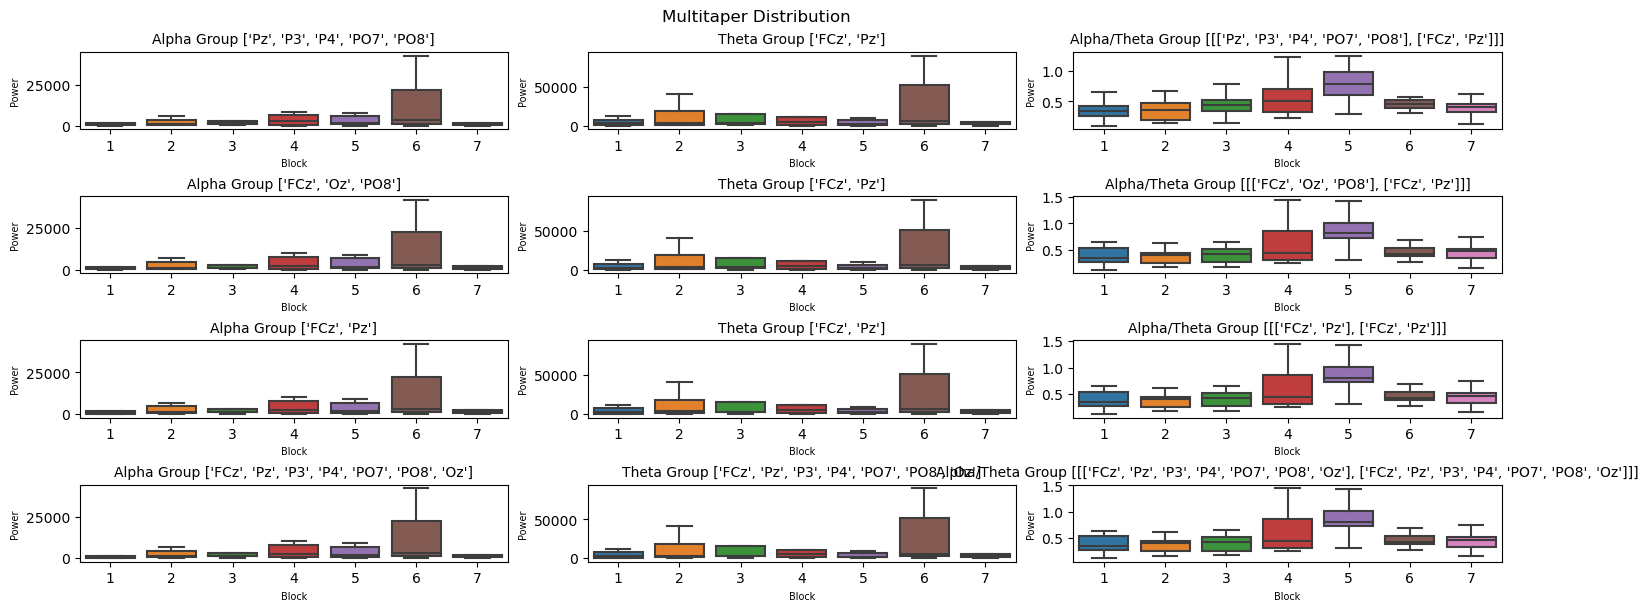

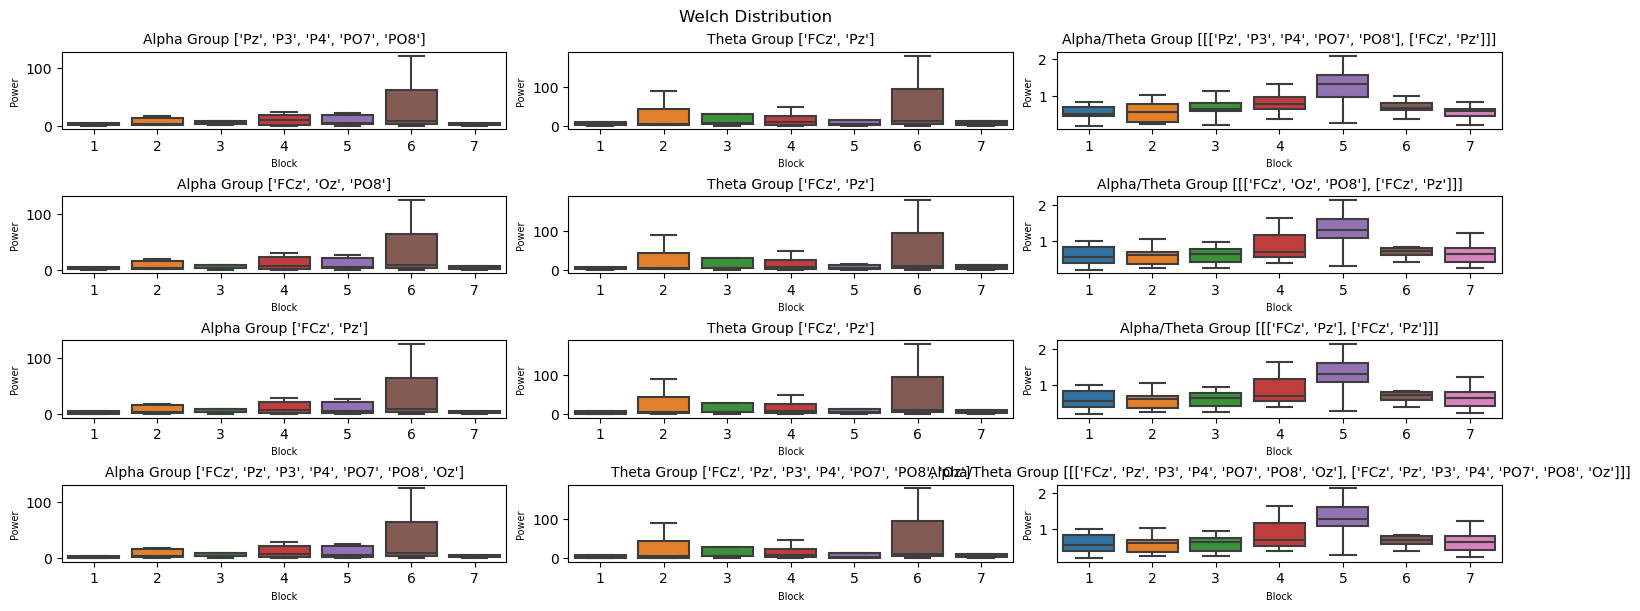

In [8]:
n_ch = len(channel_groups)
calc_powers = ['Alpha', 'Theta', 'Alpha/Theta']

f, axes = plt.subplots(n_ch, len(calc_powers), figsize=(15,6), constrained_layout=True, squeeze=False)
dfPowers  = pd.DataFrame(pws_lst, columns =['PID', 'BlockNumber', 'Alpha', 'Theta', 'Alpha/Theta', 'Group', 'Method'])

#TODO channel_groups will be 2D array dont forget. check channel_groups[i][y] of smth link that
ax_idx = 1 if len(axes) > 1 else 0
for ch_grp in range(n_ch):
    for calc_power, ax1 in enumerate(axes[ax_idx]): # up to 3
        sns.boxplot(x = "BlockNumber", y = calc_powers[calc_power], data = dfPowers.loc[(dfPowers['Group'] == ch_grp) & (dfPowers['Method'] == 'multitaper')], ax=axes[ch_grp,calc_power],showfliers=False)
        #sns.stripplot(x="BlockNumber", y = ys[i], data=dfPowers.loc[(dfPowers['Group'] == y) & (dfPowers['Method'] == 'Multitaper')], marker="o", alpha=0.3, color="black", ax=axes[y,i])
        axes[ch_grp,calc_power].set_title( str(calc_powers[calc_power]) + " Group " + str(channel_groups[ch_grp][calc_power]), fontsize=10)
        axes[ch_grp,calc_power].set_ylabel('Power', fontsize=7)
        axes[ch_grp,calc_power].set_xlabel('Block', fontsize=7)
f.suptitle("Multitaper Distribution")

f, axes = plt.subplots(n_ch, len(calc_powers), figsize=(15,6), constrained_layout=True, squeeze=False)
ax_idx = 1 if len(axes) > 1 else 0
for ch_grp in range(n_ch):
    for calc_power, ax1 in enumerate(axes[ax_idx]):
        sns.boxplot(x = "BlockNumber", y = calc_powers[calc_power], data = dfPowers.loc[(dfPowers['Group'] == ch_grp) & (dfPowers['Method'] == 'welch')], ax=axes[ch_grp,calc_power],showfliers=False)
        axes[ch_grp,calc_power].set_title( str(calc_powers[calc_power]) + " Group " +  str(channel_groups[ch_grp][calc_power]), fontsize=10)
        axes[ch_grp,calc_power].set_ylabel('Power', fontsize=7)
        axes[ch_grp,calc_power].set_xlabel('Block', fontsize=7)
f.suptitle("Welch Distribution")

plt.show()

In [9]:
dfPowers.to_pickle('./pickles/dfPowers.pickle')